In [389]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [390]:
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [391]:
# LOADING THE DATA IN THE FORM OF TRAIN AND TEST
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [392]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [393]:
# STORING THE BOOLEAN CONVERTED DATA INTO A TARGET VARIABLE AND PASSENGER DATA 
y = train_data.Transported.astype(int)
X = train_data.drop(['Transported'], axis = 1)
test_passenger_id = test_data.PassengerId

In [394]:
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [395]:
print('Shape of the train data: ', train_data.shape)

Shape of the train data:  (8693, 14)


In [396]:
# COLUMNS THAT'S NEED TO BE DROPPED 
def drop_column(dataset, columns):
    '''
    Drop the columns which are provided in the argument
    Arguments: 
    --------
        pandas.DataFrame
        columns: type.list
    Return: 
    ------
        pandas.DataFrame
    '''
    for i in columns:
        dataset = dataset.drop([i], axis = 1)
    return dataset

In [397]:
X = drop_column(X, ['PassengerId', 'Name'])
test_data = drop_column(test_data, ['PassengerId', 'Name'])

In [398]:
def mapping(dataset):
    '''
    Splits the "Cabin" column in the dataset and maps categorical values to numerical values for easier processing.
    Argument: 
    -------
        pandas.DataFrame
    Returns:
    -------
        pandas.DataFrame
    '''
    # STPIT THE FIRST AND LAST CABIN DETAILS, FORMS A NEW COLUMNS 
    dataset[['Cabin_1', 'Cabin_2']] = dataset['Cabin'].str.split('/', expand=True)[[0, 2]]
    value = sorted(pd.DataFrame(dataset.Cabin_1.value_counts()).index)
    
    # INITIAL MAPPING FOR THE CABIN_1
    cabin1_mapping = {}
    for i,v in enumerate(value):
        cabin1_mapping[v] = i+1
       
    # INITIAL MAPPING FOR THE CABIN_2
    cabin2_mapping = {'S':1, 'P':2}
    
    # MAPPING DISTRIBUTION
    dataset.Cabin_1 = dataset.Cabin_1.map(cabin1_mapping)
    dataset.Cabin_1 = dataset.Cabin_1.fillna(0)
    dataset.Cabin_2 = dataset.Cabin_2.map(cabin2_mapping)
    dataset.Cabin_2 = dataset.Cabin_2.fillna(0)
    
    # DROPPING THE CABIN COLUMNS
    
    dataset = drop_column(dataset, ['Cabin'])
    
    # RETURING THE DATASET
    return dataset

In [399]:
X = mapping(X)
test_data = mapping(test_data)

### Categorial Columnn Visualization

In [400]:
def categorical_vix(dataset):
    '''
    Plots the categorical column visualization
    Arguments:
    ---------
        pandas.DataFrame
    Return:
    ------
        matplotlib plt
    '''
    viz_columns = dataset.select_dtypes(include = ['object']).columns
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    fig.suptitle('CATEGORICAL VISUALIZATION', fontsize = 16,fontweight='bold')
    axes = axes.flatten()
    for ax, column in zip(axes, viz_columns):
        sns.countplot(x=column, data=dataset, ax=ax, color='#608BC1')
        ax.set_title(f'Count of {column}'.upper())
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.grid()
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show

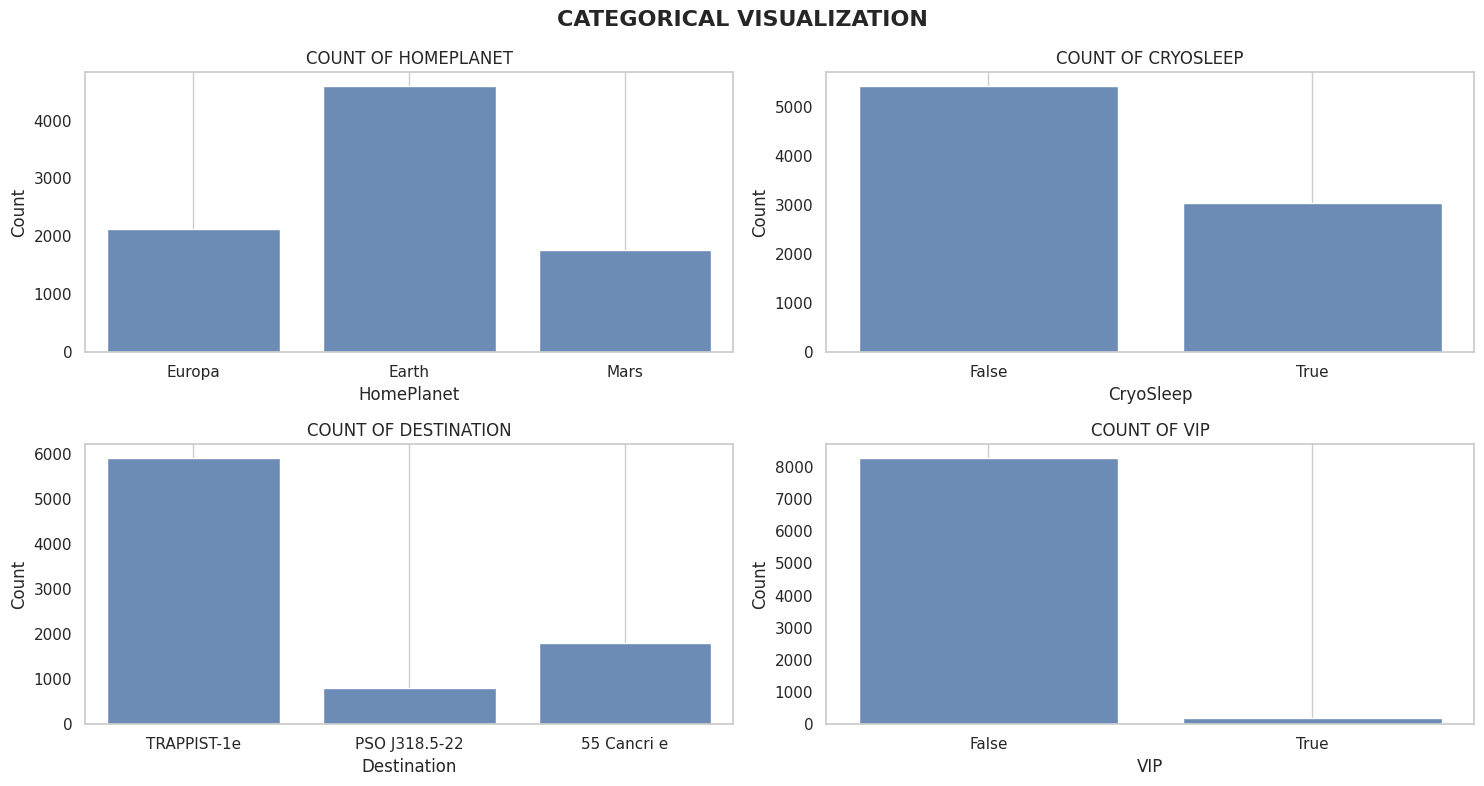

In [401]:
categorical_vix(X)

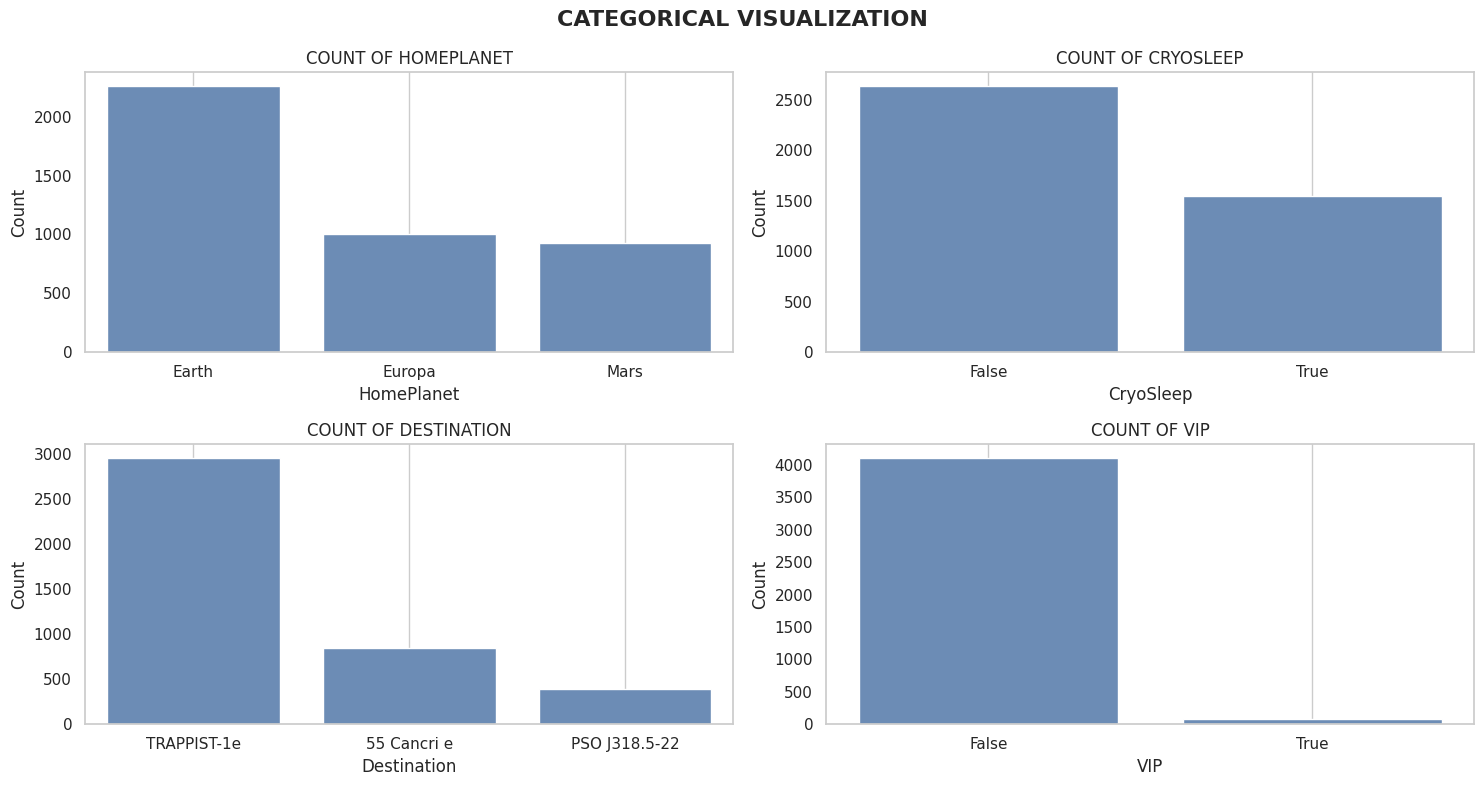

In [402]:
categorical_vix(test_data)

In [403]:
def boolen_mappig(dataset):
    '''
    Converts the boolean columns into numerical
    Arguments:
    --------
        pandas.DataFrame
    Return: 
    -------
        pandas.DataFrame
    '''
    
    # maps the boolean
    mapping = {False: 1, True: 2}
    columns_boolean = []
    columns = []
    
    # CHECKING THE CONDITION FOR THE BOOLEAN COLUMN
    for i in dataset.select_dtypes(include = ['object']):
        if type(dataset[i][0]) == bool:
            columns_boolean.append(i)
        else:
            columns.append(i)       
    
    # MAPPING THE BOOLEAN COLUMNS
    for i in columns_boolean:
        dataset[i] = dataset[i].map(mapping)
        dataset[i] = dataset[i].fillna(0)
        
    # IDENTIFYING THE COLUMNS THAT ARE NEEDED TO MAPPED BUT ARE NOT BOOLEAN
    for i in columns:
        mapping_data = {}
        data = pd.DataFrame(dataset[i].value_counts()).index
        for j,value in enumerate(data):
            mapping_data[value] = j+1
        dataset[i] = dataset[i].map(mapping)
        dataset[i] = dataset[i].fillna(0)
    
    # RETURNING THE MAPPED DATASET
    print(f"Dataset is mapped!!")
    return dataset

In [404]:
X = boolen_mappig(X)
test_data = boolen_mappig(test_data)

Dataset is mapped!!
Dataset is mapped!!


In [405]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_1,Cabin_2
0,0.0,1.0,0.0,39.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,0.0,1.0,0.0,24.0,1.0,109.0,9.0,25.0,549.0,44.0,6.0,1.0
2,0.0,1.0,0.0,58.0,2.0,43.0,3576.0,0.0,6715.0,49.0,1.0,1.0
3,0.0,1.0,0.0,33.0,1.0,0.0,1283.0,371.0,3329.0,193.0,1.0,1.0
4,0.0,1.0,0.0,16.0,1.0,303.0,70.0,151.0,565.0,2.0,6.0,1.0


In [406]:
X.Age = X.Age.fillna(X.Age.median())
test_data.Age = test_data.Age.fillna(test_data.Age.median())

In [407]:
def numerical(dataset):
    '''
    Filling the NaN numerical columns with their median value
    
    Arguments:
    ---------
        pandas.DataFrame
    Return:
    ------
        pandas.DataFrame    
    '''
    # NUMERICAL COLUMNS THAT ARE NO-NULL
    non_null_columns = dataset.columns[dataset.isnull().sum() > 0]
    
    # STORING THE NUMERICALLY NULL COLUMN
    numerical_non_null_columns = []
    for i in non_null_columns:
        if dataset[i].dtype == 'float64':
            numerical_non_null_columns.append(i)
    print(numerical_non_null_columns)
    # FILLING THE MEDIAN VALUE FOR THE PARTICULAR COLUMN
    for i in numerical_non_null_columns:
        dataset[i] = dataset[i].fillna(dataset[i].median())
        print(f'NaN value filled for column {i}')
    
    # RETURN THE DATASET
    return dataset

In [408]:
X = numerical(X)
print('-'*20)
test_data = numerical(test_data)

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
NaN value filled for column RoomService
NaN value filled for column FoodCourt
NaN value filled for column ShoppingMall
NaN value filled for column Spa
NaN value filled for column VRDeck
--------------------
['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
NaN value filled for column RoomService
NaN value filled for column FoodCourt
NaN value filled for column ShoppingMall
NaN value filled for column Spa
NaN value filled for column VRDeck


In [409]:
# FEATURE ENGINEERING 
X['Fare'] = X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
test_data['Fare'] = test_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

In [410]:
print(f'Train dataset shape {X.shape}')
print(f'Test dataset shape {test_data.shape}')

Train dataset shape (8693, 13)
Test dataset shape (4277, 13)


In [411]:
# CHECKING THE NULL COUNT FOR BOTH THE DATASETS
train_null = pd.DataFrame(X.isnull().sum(), columns = ['train'])
test_null = pd.DataFrame(test_data.isnull().sum(), columns = ['test'])
train_null.merge(test_null, left_index = True, right_index = True, how = 'outer')

,train,test
Age,0,0
Cabin_1,0,0
Cabin_2,0,0
CryoSleep,0,0
Destination,0,0
Fare,0,0
FoodCourt,0,0
HomePlanet,0,0
RoomService,0,0
ShoppingMall,0,0


In [412]:
def numerial_viz(X):
    '''
    Plots the numerical data
    Arguments:
    ---------
        pandas.DataFrame
    Return:
    ------
        maplotlib plotting
    '''
    numerical_columns = ['Fare', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows and 4 columns
    axes = axes.flatten()  # Flatten the 2D array of axes
    # Plot KDE for each numerical column
    for i, column in enumerate(numerical_columns):
        sns.kdeplot(data=X, x=column, ax=axes[i], fill=True, color='#72BF78')
        axes[i].set_title(f'KDE Plot of {column}', fontsize=14)
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Density')

    # Hide any unused subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle('KDE Plots for Numerical Columns', fontsize=16, fontweight='bold')
    plt.show()

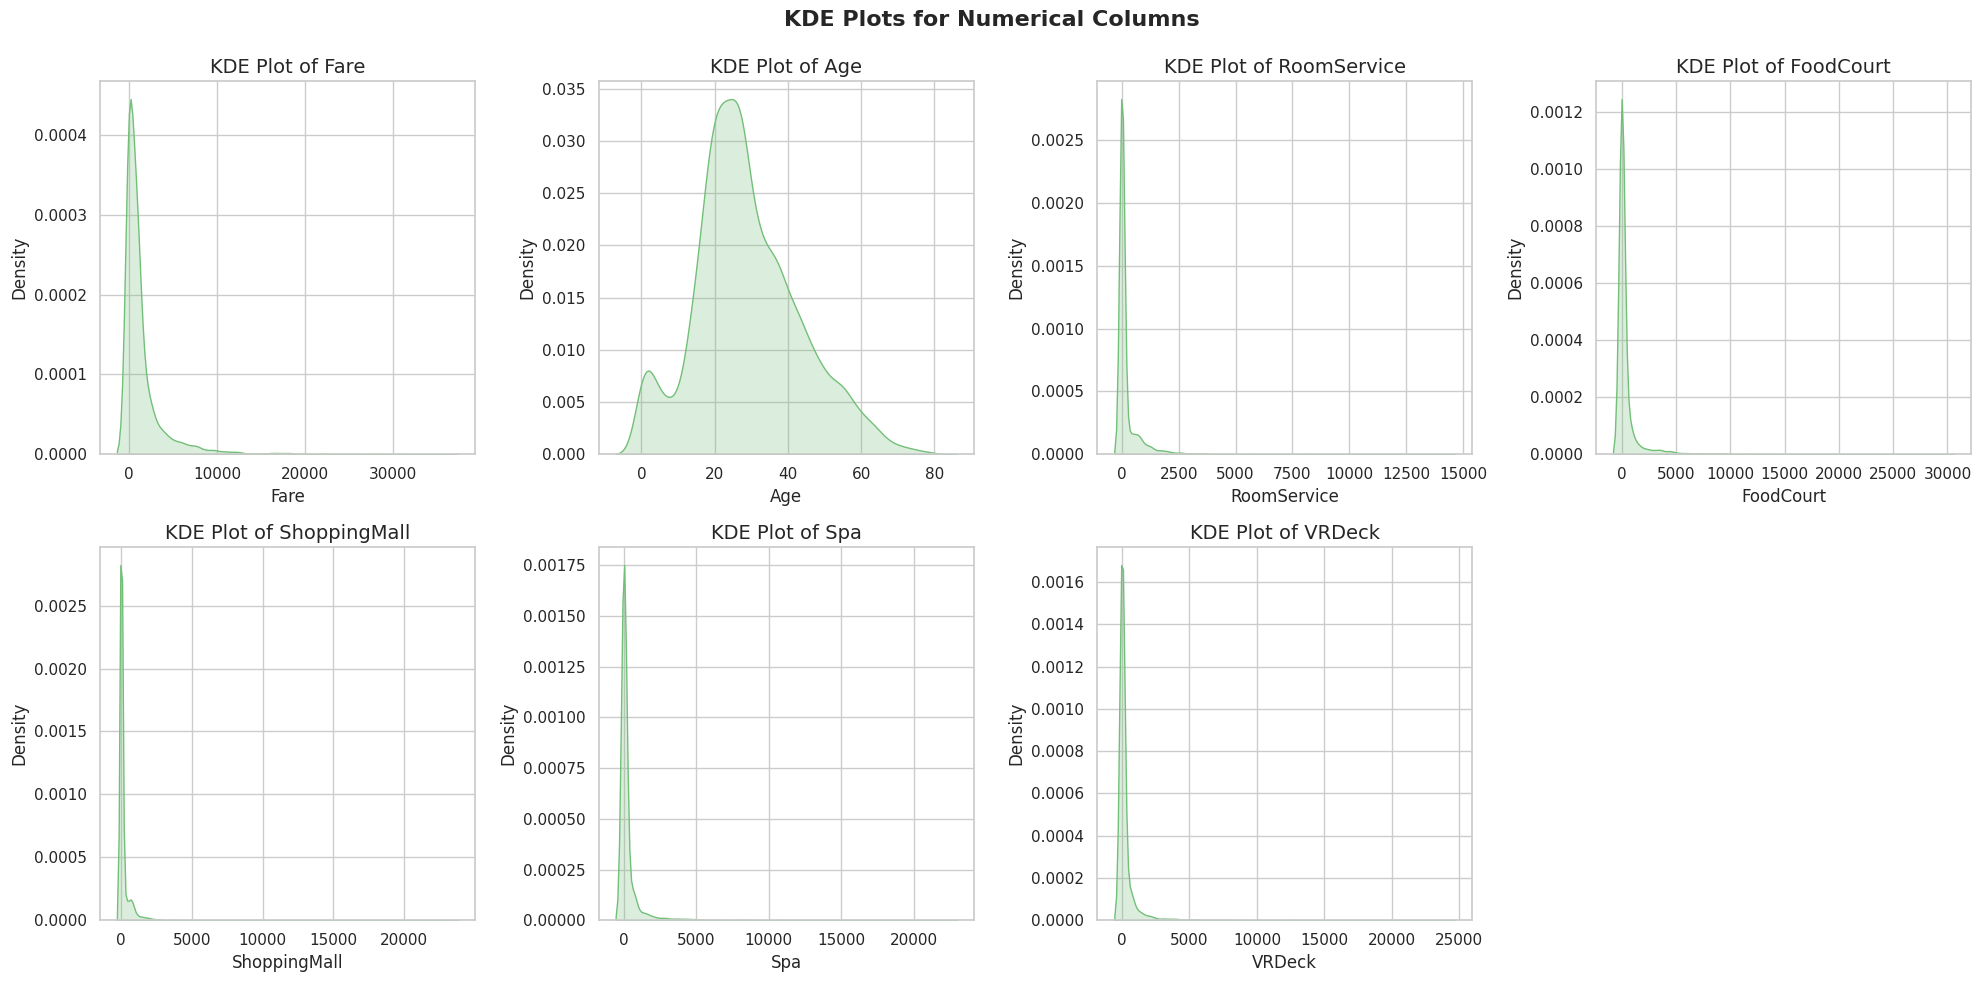

In [413]:
numerial_viz(X)

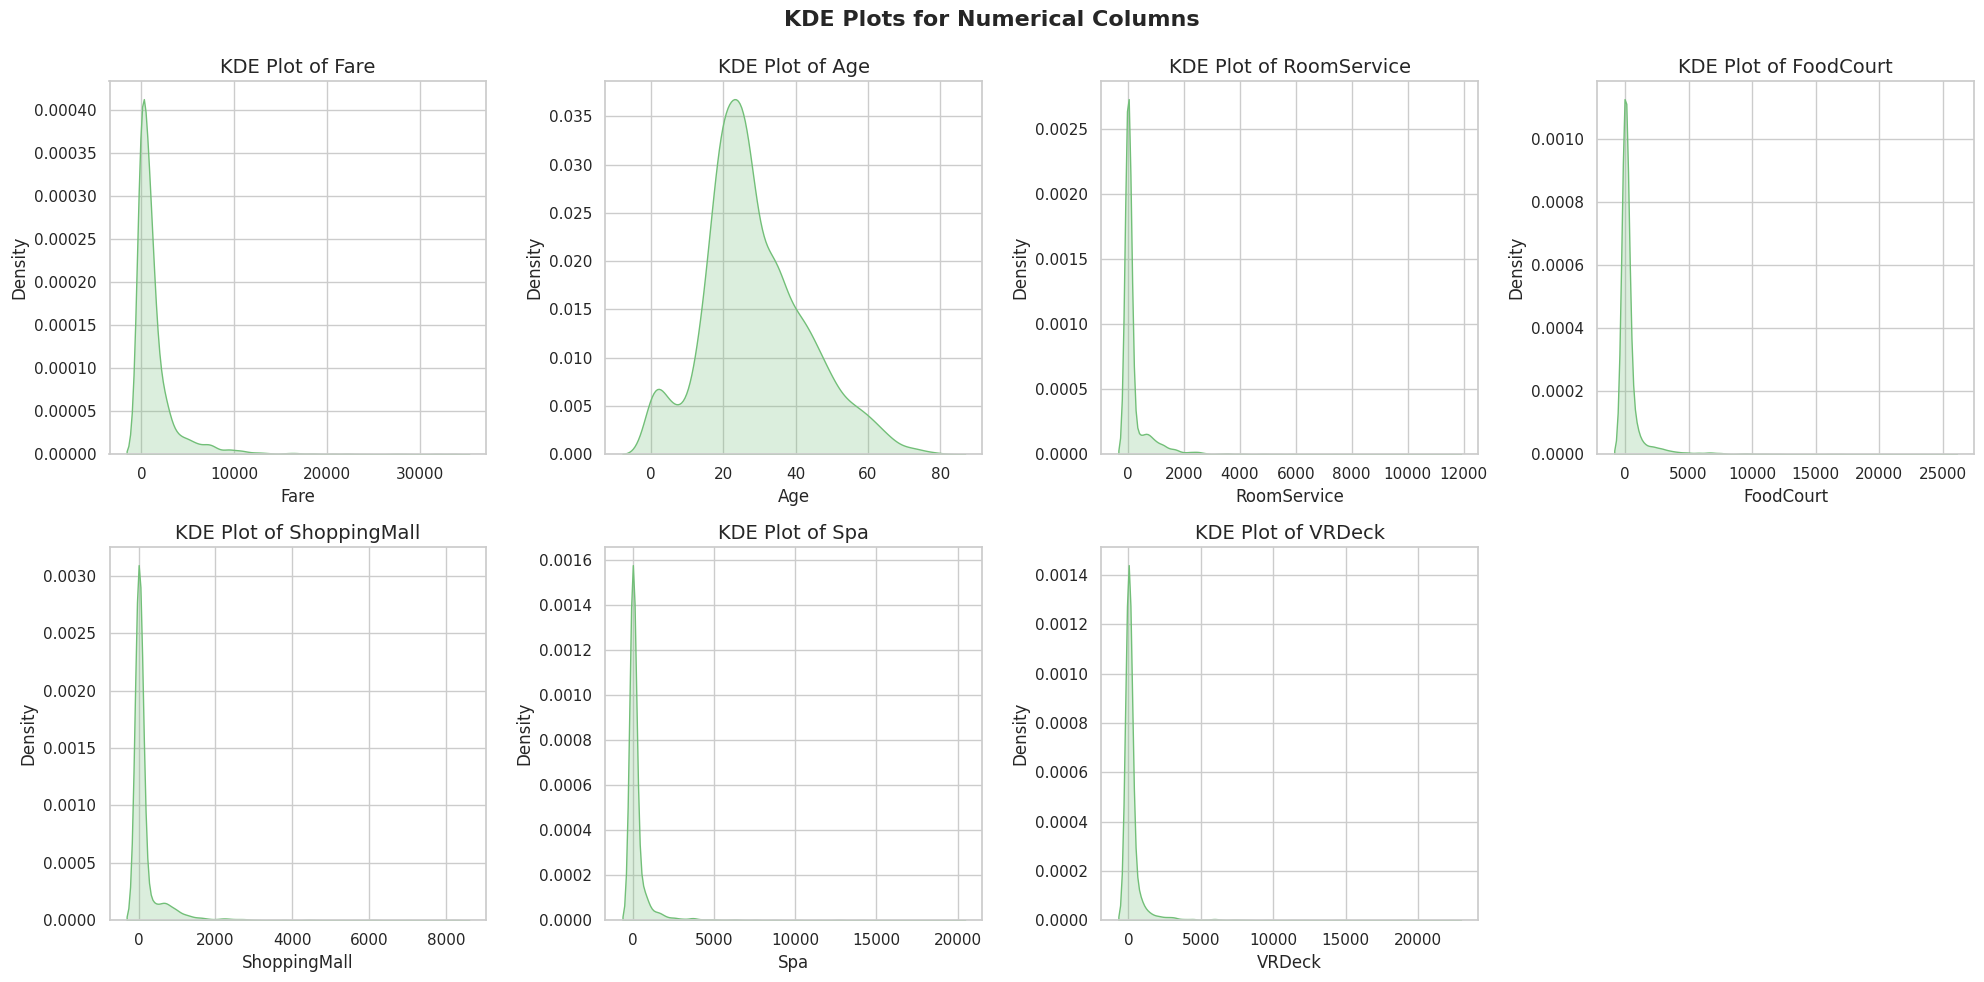

In [414]:
numerial_viz(test_data)

In [415]:
sc = StandardScaler()
sc.fit_transform(X)

array([[ 0.        , -0.62536138,  0.        , ..., -1.65102842,
         0.99372894, -0.51406554],
       [ 0.        , -0.62536138,  0.        , ...,  0.42316625,
        -0.84973791, -0.25147891],
       [ 0.        , -0.62536138,  0.        , ..., -2.16957708,
        -0.84973791,  3.1903326 ],
       ...,
       [ 0.        , -0.62536138,  0.        , ...,  0.94171492,
        -0.84973791,  0.15417463],
       [ 0.        , -0.62536138,  0.        , ..., -0.09538241,
        -0.84973791,  1.14030161],
       [ 0.        , -0.62536138,  0.        , ..., -0.09538241,
        -0.84973791,  1.20773215]])

### Train and Test Split

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [417]:
def result_metric(y_true, y_pred, model_name):
    '''
    Calculate the metrics
    Argument:
    --------
        y_ture and predicted y
    Return:
    ------
        pandas.DataFrame
    '''
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Create a DataFrame to hold the results
    results = pd.DataFrame({
        'model_name': [model_name],  # Include the model name in a new column
        'accuracy': [accuracy],
        'precision': [precision],
        'f1_score': [f1],
        'recall': [recall]
    })

    return results

### Logistic Regression 

In [418]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print('Logistic Regression Results:')
log_reg_df = result_metric(y_test, y_pred,"LogisticRegression")
log_reg_df

Logistic Regression Results:


,model_name,accuracy,precision,f1_score,recall
0,LogisticRegression,0.768212,0.746523,0.780311,0.817301


### Random Forest Classifier

In [419]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
print('Random Forest Results:')
randomforest_df = result_metric(y_test,y_pred, "RandomForestClassifier")
randomforest_df

Random Forest Results:


,model_name,accuracy,precision,f1_score,recall
0,RandomForestClassifier,0.77832,0.77839,0.780538,0.782699


In [420]:
from sklearn.model_selection import RandomizedSearchCV
randomforest_hyperparameter = RandomForestClassifier()
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 5, 10, 15],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(randomforest_hyperparameter, 
                                    param_distributions=param_distributions,
                                    n_iter=10, cv=5, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)
y_pred = random_search.predict(X_test)

print('Random Forest Hyperparameter Tuning Results:')
randomforest_hyperparameter_df = result_metric(y_test, y_pred, "RandomForestClassifier Hyperparameter")
randomforest_hyperparameter_df

Random Forest Hyperparameter Tuning Results:


,model_name,accuracy,precision,f1_score,recall
0,RandomForestClassifier Hyperparameter,0.789822,0.776247,0.796901,0.818685


In [421]:
grdboost = GradientBoostingClassifier(learning_rate = 0.001, n_estimators = 100)
grdboost.fit(X_train, y_train)
y_pred = grdboost.predict(X_test)
grdboost_df = result_metric(y_test,y_pred,"GradientBoostingClassifier")
print('Gradient Boost Results Tuning Results:')
grdboost_df

Gradient Boost Results Tuning Results:


,model_name,accuracy,precision,f1_score,recall
0,GradientBoostingClassifier,0.748693,0.702009,0.777263,0.870588


In [422]:
grdboost_hyperparameter = GradientBoostingClassifier()

# Define the hyperparameter grid
param_distributions = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'subsample': [0.5, 0.8, 1.0],
    'loss': ['log_loss', 'exponential']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(grdboost_hyperparameter, 
                                   param_distributions=param_distributions,
                                   n_iter=10, cv=5, random_state=42, n_jobs=-1)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Predict the outputs for the test set
y_pred = random_search.predict(X_test)

# Print the results
print('Gradient Boost Hyperparameter Tuning Results:')
grdboost_hyperparameter_df = result_metric(y_test, y_pred,"GradientBoostingClassifier Hyperparameter")
grdboost_hyperparameter_df

Gradient Boost Hyperparameter Tuning Results:


,model_name,accuracy,precision,f1_score,recall
0,GradientBoostingClassifier Hyperparameter,0.793656,0.771138,0.803844,0.839446


In [423]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)
adaboost_df = result_metric(y_test, y_pred,"AdaBoostClassifier")
print('Ada Boost Tuning Results:')
adaboost_df

Ada Boost Tuning Results:


,model_name,accuracy,precision,f1_score,recall
0,AdaBoostClassifier,0.781806,0.749543,0.797148,0.851211


In [424]:
adaboost_hyperparameter = AdaBoostClassifier()
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME.R', 'SAMME']
}
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=adaboost_hyperparameter, 
                                   param_distributions=param_distributions,
                                   n_iter=10, 
                                   cv=5, 
                                   random_state=42, 
                                   n_jobs=-1)

# Fit the model using the training data
random_search.fit(X_train, y_train)
# Make predictions on the test data
y_pred = random_search.predict(X_test)

# Evaluate the model performance
adaboost_hyperparameter_df = result_metric(y_test, y_pred,"AdaBoostClassifier Hyperparameter")
print('AdaBoost Hyperparameter Tuning Results:')
adaboost_hyperparameter_df

AdaBoost Hyperparameter Tuning Results:


,model_name,accuracy,precision,f1_score,recall
0,AdaBoostClassifier Hyperparameter,0.782851,0.75528,0.796072,0.841522


In [425]:
import lightgbm as lgb

# Define and train the LightGBM model
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

# Make predictions
y_pred = lgbm.predict(X_test)

# Call the result_metric function with the model name as a string
lgbm_df = result_metric(y_test, y_pred, "LGBMClassifier")

print('LGBM Tuning Results:')
lgbm_df

[LightGBM] [Info] Number of positive: 2933, number of negative: 2891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1626
[LightGBM] [Info] Number of data points in the train set: 5824, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503606 -> initscore=0.014423
[LightGBM] [Info] Start training from score 0.014423
LGBM Tuning Results:


,model_name,accuracy,precision,f1_score,recall
0,LGBMClassifier,0.794353,0.769376,0.805409,0.844983


In [426]:
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_df = result_metric(y_test, y_pred,"XGBClassifier")
print('XGBoost Tunning Result: ')
xgb_df

XGBoost Tunning Result: 


,model_name,accuracy,precision,f1_score,recall
0,XGBClassifier,0.784942,0.769883,0.792884,0.817301


In [427]:
xgb_hyperparameter = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter distribution for Randomized Search
param_distributions = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 0.1, 1]
}

# Set up the randomized search
grid_search = RandomizedSearchCV(estimator=xgb_hyperparameter, param_distributions=param_distributions,
                                  scoring='accuracy', cv=5, verbose=1, n_jobs=-1, n_iter=10)

# Fit the model
grid_search.fit(X_train, y_train)

# Make predictions
y_pred = grid_search.predict(X_test)

# Output results
print('XGBoost Hyperparameter Tuning Result: ')
xgb_hyperparameter_df = result_metric(y_test, y_pred, "XGBClassifier Hyperparameter")  # Assuming result_metric is defined
xgb_hyperparameter_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBoost Hyperparameter Tuning Result: 


,model_name,accuracy,precision,f1_score,recall
0,XGBClassifier Hyperparameter,0.793308,0.759756,0.80778,0.862284


In [428]:
from catboost import CatBoostClassifier
catboost = CatBoostClassifier(silent=True)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
print("Catboost Tunning Result: ")
catboost_df = result_metric(y_test, y_pred, "CatBoostClassifier")
catboost_df

Catboost Tunning Result: 


,model_name,accuracy,precision,f1_score,recall
0,CatBoostClassifier,0.79993,0.775459,0.810311,0.848443


In [ ]:
catboost_hyperparameters = CatBoostClassifier(silent=True)
param_distributions = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 10],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bylevel': [0.5, 0.8, 1.0],
    'bootstrap_type': ['Bernoulli', 'MVS'],
    'grow_policy': ['SymmetricTree', 'Depthwise']
}
random_search = RandomizedSearchCV(catboost_hyperparameters, param_distributions=param_distributions,
                                   cv=5, verbose=1, n_jobs=-1, n_iter=10)
random_search.fit(X_train, y_train)

# Make predictions
y_pred = random_search.predict(X_test)

# Output results
print('CatBoost Hyperparameter Tuning Result: ')
catboost_hyperparameter_df = result_metric(y_test, y_pred, "CatBoostClassifier Hyperparameter")  # Assuming result_metric is defined
catboost_hyperparameter_df

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
df = pd.concat([log_reg_df,
                randomforest_df,
                randomforest_hyperparameter_df, 
                grdboost_df,
                grdboost_hyperparameter_df,
                adaboost_df,
                adaboost_hyperparameter_df,
                lgbm_df,
                xgb_df,
                xgb_hyperparameter_df,
                catboost_df,
                catboost_hyperparameter_df], ignore_index=True)

In [ ]:
df

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Loop through each metric and plot
metrics = ['accuracy', 'precision', 'f1_score', 'recall']
for ax, metric in zip(axes.flatten(), metrics):
    # Sort DataFrame by the current metric in ascending order
    sorted_df = df.sort_values(by=metric, ascending=True)
    # Plotting
    sns.barplot(x=metric, y='model_name', data=sorted_df, palette='light:#5A9', ax=ax)
    ax.set_title(f'{metric.capitalize()} by Model')
    ax.set_xlabel(metric.capitalize())
    ax.set_ylabel('Model Name')
    ax.tick_params(axis='x', rotation=90)  # Rotate x labels

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
result = pd.DataFrame(np.where(catboost.predict(test_data)==1, True, False), columns = ['Transported'])

In [ ]:
result2 = pd.DataFrame(test_passenger_id)

In [ ]:
final = result2.merge(result, left_index = True, right_index = True, how = 'outer')

In [ ]:
final.to_csv('submission.csv', index=False)